#**Segmentation Sémantique**

In [1]:
from google.colab import drive, files
import os
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import natsort

# PyTorch
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F

#Récupération des données

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir data_segmentation

In [4]:
%%capture
!unzip drive/MyDrive/training_data.zip -d data_segmentation

# Observations des données 
Dans cette partie, on souhaite obtenir les caractéristiques des images du jeu de données.

In [5]:
def get_size(href):
  list_images_size = []
  for filename in os.scandir(href):
    if filename.is_file():
      list_images_size.append(PIL.Image.open(filename.path).size)
  return list_images_size

In [6]:
segmentation_picture_size = get_size("data_segmentation/train")
segmentation_label_size = get_size("data_segmentation/train_labels")
print("Notre jeu de données contient {} images à segmenter.".format(len(segmentation_picture_size)))
print(set(segmentation_picture_size))
print("Notre jeu de données contient {} labels.".format(len(segmentation_label_size)))
print(set(segmentation_label_size))

Notre jeu de données contient 2361 images à segmenter.
{(363, 240), (321, 240), (280, 240), (287, 240), (269, 240), (356, 240), (364, 240), (264, 240), (340, 240), (366, 240), (357, 240), (348, 240), (255, 240), (365, 240), (256, 240), (341, 240), (360, 240), (367, 240), (358, 240), (308, 240), (240, 240), (247, 240), (275, 240), (344, 240), (351, 240), (342, 240), (361, 240), (359, 240), (318, 240), (300, 240), (328, 240), (345, 240), (343, 240), (371, 240), (362, 240), (319, 240), (301, 240), (260, 240), (320, 240), (327, 240), (286, 240), (355, 240), (346, 240), (296, 240), (294, 240), (285, 240)}
Notre jeu de données contient 2361 labels.
{(363, 240), (321, 240), (280, 240), (287, 240), (269, 240), (356, 240), (364, 240), (264, 240), (340, 240), (366, 240), (357, 240), (348, 240), (255, 240), (365, 240), (256, 240), (341, 240), (360, 240), (367, 240), (358, 240), (308, 240), (240, 240), (247, 240), (275, 240), (344, 240), (351, 240), (342, 240), (361, 240), (359, 240), (318, 240), 

**Observations:**
* On dispose de 2361 images à segmenter et le même nombre de labels.
* Les images possèdent des dimensions différentes.

# Création des jeux d'entraînement, de validation et de test

In [7]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, image_dir, label_dir, images_transforms, labels_transforms, start, end):
    self.image_dir = image_dir
    self.label_dir = label_dir
    self.images_transforms = images_transforms
    self.labels_transforms = labels_transforms
    
    # Lister les images et les labels
    self.images = self.recup_files(image_dir)[start:end]
    self.labels = self.recup_files(label_dir)[start:end]

  def recup_files(self, dir):
    data=[]
    for filename in os.scandir(dir):
      if filename.is_file():
        data.append(filename.path)
    return natsort.natsorted(data) 

  def __getitem__(self, index: int):
    image_path = self.images[index]
    label_path = self.labels[index]
    image = PIL.Image.open(image_path).convert("RGB")
    label = PIL.Image.open(label_path).convert("L")
    label = PIL.ImageOps.invert(label)
    
    # Appliquer les transformations
    tensor_image = self.images_transforms(image)
    tensor_label = self.labels_transforms(label)
    return {"image":tensor_image, "label":tensor_label}

  def __len__(self):
    return len(self.images)

In [8]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

images_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)])

labels_transforms = transforms.Compose([transforms.ToTensor()])

# Création des datasets
dataset_train = ImageDataset("data_segmentation/train", "data_segmentation/train_labels", 
                             images_transforms, labels_transforms, 0, 1000)
dataset_val = ImageDataset("data_segmentation/train", "data_segmentation/train_labels", 
                           images_transforms, labels_transforms, 1000, 1800)
dataset_test = ImageDataset("data_segmentation/train", "data_segmentation/train_labels", 
                            images_transforms, labels_transforms, 1800, 2361)

In [9]:
print("Nombre d'images de train : %i." % len(dataset_train))
print("Nombre d'images de val : %i." % len(dataset_val))
print("Nombre d'images de test : %i." % len(dataset_test))

Nombre d'images de train : 1000.
Nombre d'images de val : 800.
Nombre d'images de test : 561.


In [62]:
# Création des dataloaders
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True)

# Visualisation des données
Dans cette partie, on affiche quelques photographies ainsi que quelques labels dans le but d'observer les données.

In [11]:
NB_IMAGE = 6

In [12]:
def print_images(images, rows, cols, figsize, fig_title, plot_titles = None):
  index=0
  fig = plt.figure(figsize=figsize)
  fig.suptitle(fig_title, fontsize=20)
  for row in range(rows):
    for col in range(cols):
      # Traitement de l'image
      image = images[index].cpu().detach()
      if len(image.shape) == 4:
        image = image.squeeze(0)
      if image.shape[0] == 3:
        image = image * std[:, None, None] + mean[:, None, None]

      # Affichage de l'image
      ax = fig.add_subplot(rows, cols, index+1)
      ax.imshow(transforms.ToPILImage()(image), cmap='Greys')

      # Paramètres graphiques de l'affichage
      ax.set_xticks([])
      ax.set_yticks([])
      if plot_titles is not None:
        ax.set_title(plot_titles[index])
      index=index+1

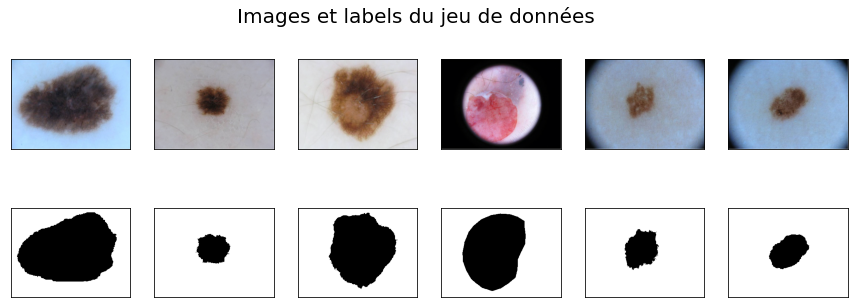

In [13]:
images_to_display = [dataset_train[i]["image"] for i in range(NB_IMAGE)]
labels_to_display = [dataset_train[i]["label"] for i in range(NB_IMAGE)]
print_images(images = images_to_display+labels_to_display, 
             rows = 2, cols = NB_IMAGE, 
             figsize = (15,5), fig_title = "Images et labels du jeu de données")

# Segmentation avec U-Net
Dans cette partie, on met en place notre architecture de réseau de neurone puis on l'entraîne sur les données d'entraînement.

## Architecture

In [14]:
class Convolution(nn.Module):
  def __init__(self, in_c, out_c):
    super(Convolution, self).__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=3, stride=1, padding="same"),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_c, out_channels=out_c, kernel_size=3, stride=1, padding="same"),
        nn.ReLU(inplace=True))
  
  def forward(self, x):
    return self.block(x)
  
class Contracte(nn.Module):
  def __init__(self, in_c, out_c):
    super(Contracte, self).__init__()
    self.conv_block = Convolution(in_c, out_c)
    self.down = nn.MaxPool2d(kernel_size=2, stride=2)
  
  def forward(self, x):
    x = self.conv_block(x)
    return x, self.down(x)

class Expanse(nn.Module):
  def __init__(self, in_c, out_c):
    super(Expanse, self).__init__()
    self.up = nn.ConvTranspose2d(in_channels=in_c, out_channels=out_c, kernel_size=2, stride=2)
    self.conv_block = Convolution(in_c, out_c)
  
  def forward(self, x1, x2):
    x1 = self.up(x1)
    # Pour corriger la taille de l'image si besoin
    diffX = x2.size()[3] - x1.size()[3]
    diffY = x2.size()[2] - x1.size()[2]
    x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                    diffY // 2, diffY - diffY//2))
    x1 = torch.concat([x2, x1], axis=1)
    return self.conv_block(x1)

In [15]:
class U_Net(nn.Module):
  def __init__(self):
    super(U_Net, self).__init__()
    self.contracte1 = Contracte(in_c=3, out_c=64)
    self.contracte2 = Contracte(in_c=64, out_c=128)
    self.contracte3 = Contracte(in_c=128, out_c=256)
    self.contracte4 = Contracte(in_c=256, out_c=512)
    self.conv_block = Convolution(in_c = 512, out_c=1024)
    self.expanse4 = Expanse(in_c=1024, out_c=512)
    self.expanse3 = Expanse(in_c=512, out_c=256)
    self.expanse2 = Expanse(in_c=256, out_c=128)
    self.expanse1 = Expanse(in_c=128, out_c=64)
    self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, padding=0, stride=1)
  
  def forward(self, x):
    contracte1, x = self.contracte1(x)
    contracte2, x = self.contracte2(x)
    contracte3, x = self.contracte3(x)
    contracte4, x = self.contracte4(x)
    x = self.conv_block(x)
    x = self.expanse4(x, contracte4)
    x = self.expanse3(x, contracte3)
    x = self.expanse2(x, contracte2)
    x = self.expanse1(x, contracte1)
    return self.out(x)

## Préparation de l'entraînement

In [16]:
def evaluate(model, dataloader):
    avg_loss = 0.
    avg_accuracy = 0.

    for i, data in enumerate(dataloader):
      inputs=data["image"]
      labels=data["label"]
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      
      loss = criterion(outputs, labels)
      preds = torch.where(outputs>=0, 1, 0)
      n_correct = torch.sum(preds == labels).item()/(outputs.shape[2]*outputs.shape[3])
      avg_loss += loss.item()
      avg_accuracy += n_correct
        
    return avg_loss/len(dataloader), avg_accuracy/len(dataloader)

In [17]:
def train_model(model, loader_train, loader_val, optimizer, criterion, n_epochs, scheduler=False):
  
  # Définission la décroissance du learning rate
  if scheduler:
    lmbda = lambda epoch: 1.0 - max(0, epoch + 10 - 20) / float(10 + 1)
  else:
    lmbda = lambda epoch: 1
  lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lmbda)

  saved_loss_train = []
  saved_loss_val = []
  saved_acc = []
  for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    # itère sur les minibatchs via le loader d'apprentissage
    loss_train = 0.
    for i, data in enumerate(loader_train): 
      inputs=data["image"]
      labels=data["label"]
      # on passe les données sur CPU / GPU
      inputs, labels = inputs.to(device), labels.to(device) 
      # on réinitialise les gradients
      optimizer.zero_grad() 
      # on calcule l'output
      outputs = model(inputs) 
      
      # on calcule la loss
      loss = criterion(outputs, labels) 
      loss_train = loss_train + loss.item()
      loss.backward() # on effectue la backprop pour calculer les gradients
      optimizer.step() # on update les gradients en fonction des paramètres

    loss_train = loss_train/len(loader_train)
    model.train(False)
    with torch.no_grad():
      loss_val, accuracy = evaluate(model, loader_val)
    model.train(True)
    print("Epoch n°{} loss train total: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}\tLR : {:1.9f}".format(epoch, loss_train, 
                                                                                                       loss_val, accuracy,
                                                                                                       optimizer.param_groups[0]['lr']))
    
    lr_scheduler.step() # on met à jour le learning rate
    saved_loss_train.append(loss_train)
    saved_loss_val.append(loss_val)
    saved_acc.append(accuracy)

  return saved_loss_train,saved_loss_val,saved_acc

In [18]:
sns.set_theme()
def print_results(losses, losses_labels=None):
  # Mise en place des plots et des titres
  fig, ax = plt.subplots(1, 3, figsize=(15,5))
  fig.suptitle("Fonctions de coût et accuracy au cours de l'apprentissage", fontsize=15)
  ax[0].set_title("Train Loss Function")
  ax[1].set_title("Validation Loss Function")
  ax[2].set_title("Validation Pixel-Wise Accuracy")
  # Ajout des informations
  for index_loss in range(len(losses)):
    for index in range(0,3):
      ordonnee = losses[index_loss][index]
      abscisse = [x for x in range(len(ordonnee))]
      data_label = losses_labels[index_loss] if losses_labels is not None else None
      sns.lineplot(x = abscisse, y = ordonnee, label=data_label, ax=ax[index])

## Entraînement

In [19]:
# on utilisera le GPU (beaucoup plus rapide) si disponible, sinon on utilisera le CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Reproductibilité
torch.manual_seed(10)

cuda:0


In [20]:
model = U_Net()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [21]:
model.train(True)
train_losses, val_losses, accuracy =train_model(model, loader_train, loader_val, optimizer, criterion, n_epochs=20)

Epoch n°0 loss train total: 0.4331	 val 0.4380	Acc (val): 80.8%	LR : 0.000100000
Epoch n°1 loss train total: 0.3909	 val 0.3552	Acc (val): 84.4%	LR : 0.000100000
Epoch n°2 loss train total: 0.3813	 val 0.4207	Acc (val): 80.6%	LR : 0.000100000
Epoch n°3 loss train total: 0.3686	 val 0.4411	Acc (val): 80.1%	LR : 0.000100000
Epoch n°4 loss train total: 0.3323	 val 0.4018	Acc (val): 81.5%	LR : 0.000100000
Epoch n°5 loss train total: 0.2842	 val 0.4684	Acc (val): 78.9%	LR : 0.000100000
Epoch n°6 loss train total: 0.2503	 val 0.2659	Acc (val): 89.2%	LR : 0.000100000
Epoch n°7 loss train total: 0.2250	 val 0.3993	Acc (val): 86.3%	LR : 0.000100000
Epoch n°8 loss train total: 0.1982	 val 0.5235	Acc (val): 79.7%	LR : 0.000100000
Epoch n°9 loss train total: 0.1833	 val 0.5109	Acc (val): 81.5%	LR : 0.000100000
Epoch n°10 loss train total: 0.1636	 val 0.4199	Acc (val): 85.8%	LR : 0.000100000
Epoch n°11 loss train total: 0.1615	 val 0.3018	Acc (val): 87.9%	LR : 0.000100000
Epoch n°12 loss train tota

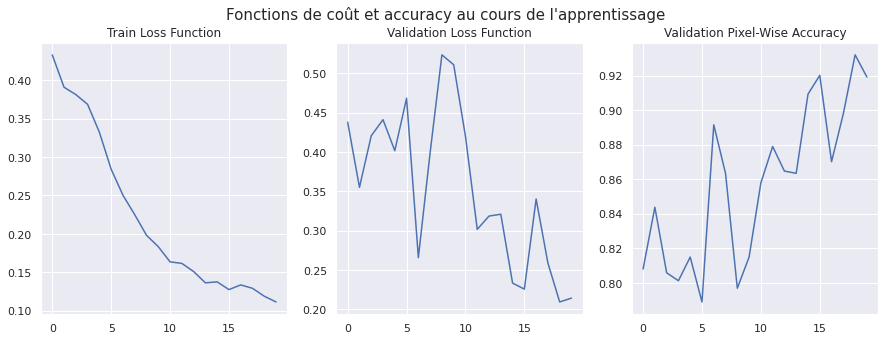

In [24]:
print_results(losses=[[train_losses, val_losses, accuracy]])

In [25]:
UNET1_losses = [train_losses, val_losses, accuracy]

## Entraînement - Ajout d'un learning rate décroissant

In [26]:
model_v2 = U_Net()
model_v2 = model_v2.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr=1e-4)

In [27]:
model_v2.train(True)
train_losses, val_losses, accuracy = train_model(model_v2, loader_train, loader_val, optimizer, criterion, n_epochs=20, scheduler=True)

Epoch n°0 loss train total: 0.4272	 val 0.4913	Acc (val): 77.6%	LR : 0.000100000
Epoch n°1 loss train total: 0.3871	 val 0.5394	Acc (val): 78.4%	LR : 0.000100000
Epoch n°2 loss train total: 0.3795	 val 0.3551	Acc (val): 86.0%	LR : 0.000100000
Epoch n°3 loss train total: 0.3732	 val 0.4661	Acc (val): 78.6%	LR : 0.000100000
Epoch n°4 loss train total: 0.3598	 val 0.4809	Acc (val): 80.3%	LR : 0.000100000
Epoch n°5 loss train total: 0.3528	 val 0.4928	Acc (val): 88.0%	LR : 0.000100000
Epoch n°6 loss train total: 0.3593	 val 0.4009	Acc (val): 83.2%	LR : 0.000100000
Epoch n°7 loss train total: 0.2796	 val 0.4871	Acc (val): 81.3%	LR : 0.000100000
Epoch n°8 loss train total: 0.2352	 val 0.2347	Acc (val): 92.2%	LR : 0.000100000
Epoch n°9 loss train total: 0.2074	 val 0.2956	Acc (val): 89.0%	LR : 0.000100000
Epoch n°10 loss train total: 0.1794	 val 0.2515	Acc (val): 90.5%	LR : 0.000100000
Epoch n°11 loss train total: 0.1619	 val 0.3227	Acc (val): 88.1%	LR : 0.000090909
Epoch n°12 loss train tota

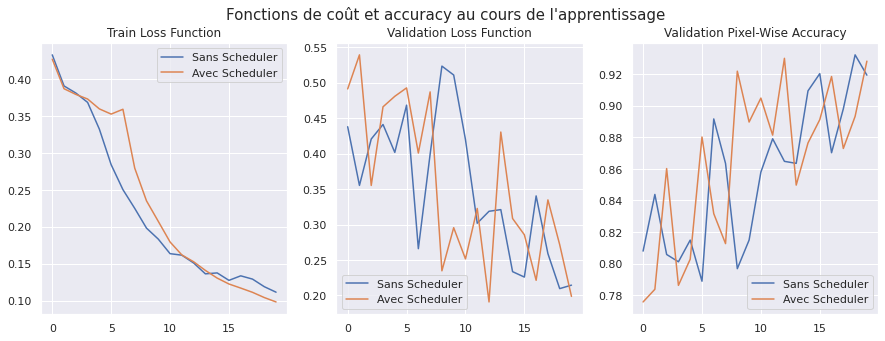

In [28]:
print_results(losses=[UNET1_losses, [train_losses, val_losses, accuracy]], losses_labels=["Sans Scheduler", "Avec Scheduler"])

## Résultats

In [29]:
final_model = model_v2

In [32]:
# on enregistre les poids du model
torch.save(final_model.state_dict(), "checkpoint.pth")
# On télécharge le fichier
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
# on affiche les masques générés
final_model.train(False)
results = []
with torch.no_grad():
  for i, data in enumerate(loader_test): 
    inputs=data["image"]
    labels=data["label"]
    outputs=model(inputs.to(device))
    outputs = outputs.squeeze(0)
    outputs = outputs.squeeze(0)
    outputs = torch.where(outputs>=0, 1., 0.)
    results.append(inputs)
    results.append(labels)
    results.append(outputs)
    if i==10:
      break

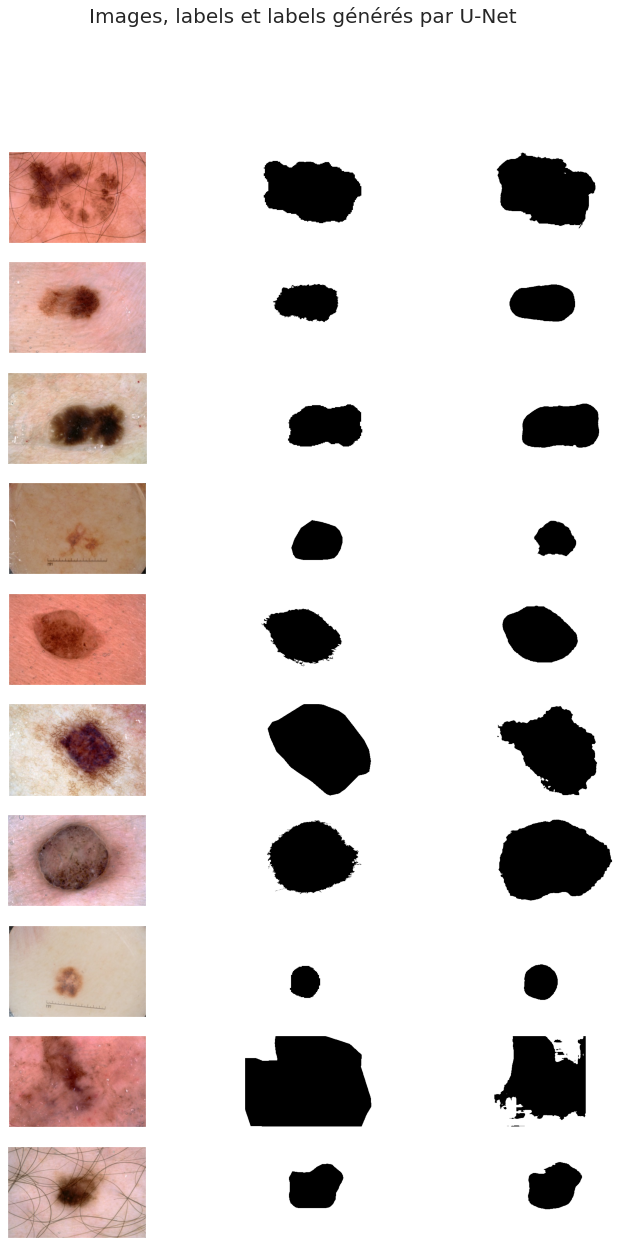

In [72]:
print_images(images = results, rows = 10, cols = 3, 
             figsize = (12,20), fig_title = "Images, labels et labels générés par U-Net")